In [34]:
## DriveEasy exploration notebook for off-line event extraction and lane assignment test. 
## Last updates 12/10/2020
## author-qchen@parc.com
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.signal as signal
import datetime
from pathlib import Path

FIBER_DISTANCE = 2.5
SAMPLING_RATE = 200
THRESHOLD = 0.001 # picometer
BIN_SIZE = 40


class EventProperties:
    def __init__(self):
        self.timestamp = 0
        self.start = 0
        self.end = 1
        self.speed = 0
        self.ch = 1
        self.location = 1
        self.sensor = []
        self.axles = 0
        self.axle_lengths = []


class Event:
    def __init__(self):
        self.timestamp = datetime.datetime.now()
        self.event_id = 0
        self.fiber1_id = 0
        self.fiber2_id = 0
        self.fiber1_sensors = []
        self.fiber2_sensors = []
        self.info = ''
        self.wav1 = []
        self.wav2 = []

        
def normalize_tomax(wav):
    wav = (wav-np.min(wav))/(np.max(wav)-np.min(wav))
    return wav


def define_baseline_alg1(data_seg, threshold):
    if np.max(np.abs(data_seg - np.mean(data_seg))) > threshold:
        return 1
    else:
        return 0


# define the minimum distance in time between two vehicles: BIN_SIZE
def event_detection(data_trace, threshold=0.001, seg_length=BIN_SIZE):
    event_flag = []
    for i in range(int(len(data_trace)/seg_length)):
        event_flag.append(define_baseline_alg1(data_trace[i*seg_length:(i+1)*seg_length], threshold=threshold))
    return event_flag


def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')


def de_trend(data, n_ave=200):
    trend = moving_average(data, periods=n_ave)
    return data[:-(n_ave - 1)] - trend


def subtract_firstrow(df):
    first_row = df.iloc[[0]].values[0]
    df_temp = df.apply(lambda row: row - first_row, axis=1)
    return df_temp


def read_npz_file(filename):
    data = np.load(filename, allow_pickle=True)
    df = pd.DataFrame(data=data['wav'], index=data['timestamp'])

    df.columns = [f'sensor{i+1}' for i in range(25)]
    try:
        df['linenum'] = data['linenum']
    except:
        print('no linenum found')
    return df


def clean_wav(fiber):
    df_fiber = fiber
    check = df_fiber.index.to_series().diff().dt.total_seconds()
    df = pd.DataFrame(index=(df_fiber[check.values>0.006].index-datetime.timedelta(seconds=0.005)), columns=df_fiber[check.values>0.006].columns)
    df_fiber = df_fiber.append(df, ignore_index=False)
    df_fiber = df_fiber.sort_index()
    df_fiber.reset_index(inplace=True)
    #df_fiber.columns = ['timestamp'] + [f'sensor{i+1}' for i in range(25)] + ['linenum']
    df_fiber.columns = ['timestamp'] + [f'sensor{i+1}' for i in range(25)]
    return df_fiber


def find_outliers(df, total_sensorn=25, percent_low=0.001, percent_high=0.99999):

    y = df['sensor24']
    removed_outliers = y.between(y.quantile(0.5)-0.2, y.quantile(0.5)+0.2)

    for i in range(total_sensorn):
        y = df[f'sensor{i+1}']
        if np.max([y.max() - y.mean(), y.mean() - y.min()])> 0.5:
            removed_outliers = y.between(y.quantile(0.5)-0.5, y.quantile(0.5)+0.5) & removed_outliers
    index_names = df[~removed_outliers].index
    return index_names

def remove_outliers_from_paired_fibers(outlier_ch1, outlier_ch2, df_1, df_2):
    total_outliers = list(dict.fromkeys(outlier_ch1.to_list() + outlier_ch2.to_list()))
    df_1.loc[total_outliers, [f'sensor{i + 1}' for i in range(25)]] = np.nan
    df_2.loc[total_outliers, [f'sensor{i + 1}' for i in range(25)]] = np.nan

    # fix missing data in the middle using interpolate
    df_1.interpolate(inplace=True)
    df_2.interpolate(inplace=True)

    # fix missing data in the head
    df_1 = df_1.fillna(method='bfill')
    df_2 = df_2.fillna(method='bfill')
    return df_1, df_2


In [35]:
data_path = Path(r'D:\--System--\Matt\Documents\FiBridge\DriveEasy_francis_st\VIPER VIM validation\1120-1122\driveeasy_wav\melbourne_time_20201120_0900AM')
#D:\--System--\Matt\Documents\FiBridge\DriveEasy_francis_st\VIPER VIM validation\1120-1122\driveeasy_wav\melbourne_time_20201120_0100AM
filename_1 = data_path / r'wav_20201119_215814_F01_UTC.npz'
filename_2 = data_path / r'wav_20201119_215814_F02_UTC.npz'
filename_3 = data_path / r'wav_20201119_215814_F03_UTC.npz'
filename_4 = data_path / r'wav_20201119_215814_F04_UTC.npz'

WindowsPath('D:/--System--/Matt/Documents/FiBridge/DriveEasy_francis_st/VIPER VIM validation/1120-1122/driveeasy_wav/melbourne_time_20201120_0100AM/wav_20201119_135905_F01_UTC.npz')

In [36]:
### npz
df_1 = read_npz_file(filename_1)
df_2 = read_npz_file(filename_2)
df_3 = read_npz_file(filename_3)
df_4 = read_npz_file(filename_4)

no linenum found
no linenum found
no linenum found
no linenum found


In [37]:
df_1

,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
2020-11-19 21:58:14.000000,1511.8229,1515.1537,1518.7277,1522.0399,1525.4781,1528.6747,1531.8113,1534.7644,1539.6825,1540.9128,...,1560.4520,1563.6265,1566.8477,1569.9792,1573.1599,1576.0953,1578.9398,1581.8776,1584.9023,1588.4904
2020-11-19 21:58:14.005009,1511.8228,1515.1539,1518.7273,1522.0398,1525.4783,1528.6750,1531.8113,1534.7649,1539.6824,1540.9130,...,1560.4520,1563.6261,1566.8477,1569.9795,1573.1598,1576.0952,1578.9395,1581.8774,1584.9021,1588.4906
2020-11-19 21:58:14.010017,1511.8230,1515.1538,1518.7278,1522.0399,1525.4783,1528.6750,1531.8114,1534.7646,1539.6825,1540.9125,...,1560.4518,1563.6262,1566.8475,1569.9792,1573.1597,1576.0951,1578.9397,1581.8774,1584.9021,1588.4907
2020-11-19 21:58:14.015026,1511.8231,1515.1541,1518.7275,1522.0402,1525.4784,1528.6748,1531.8115,1534.7648,1539.6826,1540.9128,...,1560.4521,1563.6259,1566.8478,1569.9794,1573.1597,1576.0951,1578.9396,1581.8774,1584.9020,1588.4907
2020-11-19 21:58:14.020034,1511.8230,1515.1537,1518.7275,1522.0400,1525.4781,1528.6750,1531.8115,1534.7646,1539.6824,1540.9130,...,1560.4520,1563.6261,1566.8475,1569.9794,1573.1595,1576.0951,1578.9398,1581.8774,1584.9021,1588.4907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19 22:09:20.979966,1511.8323,1515.1616,1518.7367,1522.0547,1525.4795,1528.6813,1531.8235,1534.7841,1539.6665,1540.9380,...,1560.4675,1563.6488,1566.8694,1569.9580,1573.1390,1576.0897,1578.9348,1581.8762,1584.9047,1588.4939
2020-11-19 22:09:20.984974,1511.8325,1515.1615,1518.7367,1522.0544,1525.4801,1528.6815,1531.8232,1534.7838,1539.6665,1540.9376,...,1560.4677,1563.6489,1566.8694,1569.9581,1573.1388,1576.0895,1578.9349,1581.8765,1584.9047,1588.4938
2020-11-19 22:09:20.989983,1511.8325,1515.1615,1518.7369,1522.0547,1525.4796,1528.6812,1531.8234,1534.7839,1539.6664,1540.9379,...,1560.4673,1563.6489,1566.8694,1569.9579,1573.1388,1576.0897,1578.9346,1581.8765,1584.9047,1588.4938
2020-11-19 22:09:20.994991,1511.8325,1515.1616,1518.7369,1522.0548,1525.4795,1528.6813,1531.8236,1534.7838,1539.6664,1540.9379,...,1560.4675,1563.6490,1566.8693,1569.9581,1573.1388,1576.0900,1578.9346,1581.8765,1584.9048,1588.4938


In [38]:
print(len(df_1))
print(len(df_2))
print(len(df_3))
print(len(df_4))

133169
133172
133170
133170


In [39]:
df_1 = clean_wav(df_1)
df_2 = clean_wav(df_2)
df_3 = clean_wav(df_3)
df_4 = clean_wav(df_4)

In [40]:
outliers_1 = find_outliers(df_1, total_sensorn=25, percent_low=0.000005, percent_high=0.99995)
outliers_2 = find_outliers(df_2, total_sensorn=25, percent_low=0.000005, percent_high=0.99995)
outliers_3 = find_outliers(df_3, total_sensorn=24, percent_low=0.000005, percent_high=0.99995)
outliers_4 = find_outliers(df_4, total_sensorn=25, percent_low=0.000005, percent_high=0.99995)

In [41]:
print(len(outliers_1))
print(len(outliers_2))
print(len(outliers_3))
print(len(outliers_4))

3
5
10
58476


In [42]:
trim_outliers = False
if trim_outliers:
    dff_1, dff_2 = remove_outliers_from_paired_fibers(outliers_1, outliers_2, df_1, df_2)
    dff_3, dff_4 = remove_outliers_from_paired_fibers(outliers_3, outliers_4, df_3, df_4)
else:
    dff_1 = df_1
    dff_2 = df_2
    dff_3 = df_3
    dff_4 = df_4

In [43]:
dff_2.head(5)
# df_2.tail(1)

,timestamp,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,...,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25
0,2020-11-19 21:58:14.000000,1511.7307,1515.2465,1518.8767,1522.1816,1525.5591,1528.9075,1532.0925,1535.1404,1539.7866,...,1560.7665,1564.0347,1567.2578,1570.4313,1573.7571,1576.8145,1579.8116,1582.6786,1585.1265,1588.1023
1,2020-11-19 21:58:14.005009,1511.7308,1515.2465,1518.8767,1522.1818,1525.5591,1528.9077,1532.0925,1535.1405,1539.7867,...,1560.7664,1564.0345,1567.2576,1570.4314,1573.7571,1576.8145,1579.8116,1582.6785,1585.1265,1588.1025
2,2020-11-19 21:58:14.010017,1511.7311,1515.2466,1518.8767,1522.1816,1525.5592,1528.9077,1532.0924,1535.1404,1539.7866,...,1560.7662,1564.0347,1567.2578,1570.4315,1573.7570,1576.8146,1579.8116,1582.6783,1585.1266,1588.1024
3,2020-11-19 21:58:14.015026,1511.7308,1515.2465,1518.8767,1522.1816,1525.5592,1528.9077,1532.0923,1535.1406,1539.7866,...,1560.7661,1564.0348,1567.2577,1570.4314,1573.7570,1576.8145,1579.8116,1582.6786,1585.1266,1588.1023
4,2020-11-19 21:58:14.020034,1511.7310,1515.2465,1518.8766,1522.1818,1525.5591,1528.9076,1532.0924,1535.1404,1539.7866,...,1560.7665,1564.0347,1567.2577,1570.4314,1573.7570,1576.8145,1579.8116,1582.6785,1585.1266,1588.1024


<AxesSubplot:>

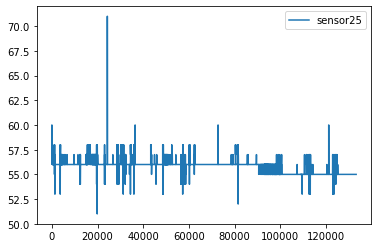

In [44]:
dff_4.plot(y=['sensor25'])

In [12]:
# trim error lines in the head if there is any
# dff_1 = dff_1.iloc[1:,:]
# dff_1.reset_index(drop=True,inplace=True)
# dff_2 = dff_2.iloc[1:,:]
# dff_2.reset_index(drop=True, inplace=True)

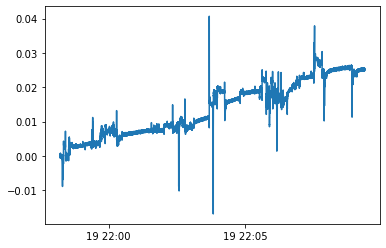

In [45]:
# exam the loaded data
# set index of sensor to look at
import matplotlib.dates as mdates
k = 9
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)

# # if there is a built-in timestamp
ax.plot(np.asarray(dff_1.iloc[:, 0]), np.asarray(dff_1.iloc[:, k+1])-dff_1.iloc[0,k+1], label='ch_1')
# ax.plot(df_2.iloc[:, 0], np.asarray(df_2.iloc[:, k])-df_2.iloc[0,k], label='ch_2')

# ax.set_ylim([-0.05, 0.05])

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H-%M-%s-%f'))
# fig.autofmt_xdate()

# ax.plot(np.asarray(dff_1.iloc[:, 4]), 'r', label='ch_1')
# ax.plot(np.asarray(dff_2.iloc[:, 23]), 'b', label='ch_2')
# ax.plot(np.asarray(dff_2.iloc[:, 8]), 'g', label='ch_2')
# ax.plot(np.asarray(df_2.iloc[:40000, k+1]), 'g', label='ch_2')

In [46]:
# Francis ch1, ch2: lane3_3_15; lane4_16_25; lane2_11-23; lane1_1_10 # start from 1 here
# M80 ch3, ch4: lane5_1_11; lane4_12_21; lane3_; lane2_
street_id = 'Francis'
lane_id = 1

sensor_arrangement = {'Francis':[[], list(range(1, 11)), list(range(11, 24)), list(range(3,16)), list(range(16, 26))], 
                      'M80':[[], [], list(range(16, 26)), list(range(6, 16)), list(range(12, 22)), list(range(1, 12))]}

lane_sensor = sensor_arrangement[street_id][lane_id]

In [47]:
lane_sensor

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [48]:
# Identify the triggering fiber. lane1,2, df_3, df_4; lane 3, 4, df_1,2
trace_leading = np.asarray(dff_3.loc[:,[f'sensor{i}' for i in lane_sensor]])
trace_trailing = np.asarray(dff_4.loc[:,[f'sensor{i}' for i in lane_sensor]])

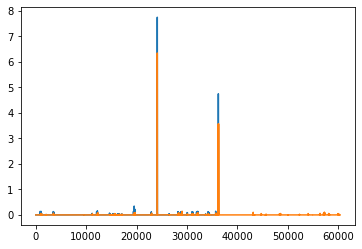

In [49]:
#de_trend and aggregate sensor signal, high pass filtering

sos = signal.butter(2, 5, 'hp', fs=SAMPLING_RATE, output='sos')
filtered_wav1 = signal.sosfilt(sos, trace_leading, axis=0)
filtered_wav2 = signal.sosfilt(sos, trace_trailing, axis=0)

trace_leading = np.max(np.abs(filtered_wav1[SAMPLING_RATE:, :]), axis=1)
trace_trailing = np.max(np.abs(filtered_wav2[SAMPLING_RATE:, :]), axis=1)

plt.figure()
plt.plot(trace_leading)
plt.plot(trace_trailing)
plt.show()

In [50]:
# BIN_SIZE=40
# for i in range(len(trace_leading[0])):
#     trace_leading[:len(trace_leading)-BIN_SIZE+1,i]=de_trend(trace_leading[:,i], n_ave=BIN_SIZE)
#     trace_trailing[:len(trace_trailing)-BIN_SIZE+1,i]=de_trend(trace_trailing[:,i], n_ave=BIN_SIZE)

# trace_leading = np.max(np.abs(trace_leading[:len(trace_leading)-BIN_SIZE+1, :]), axis=1)
# trace_trailing = np.max(np.abs(trace_trailing[:len(trace_trailing)-BIN_SIZE+1, :]), axis=1)

In [51]:

event_vis_leading = event_detection(trace_leading, threshold=0.0008, seg_length=BIN_SIZE)
event_vis_trailing = event_detection(trace_trailing, threshold=0.0008, seg_length=BIN_SIZE)

Total peak detected: 26
Total peak detected: 49
Total peak detected: 48


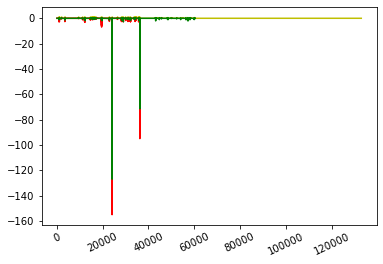

In [52]:
timeseg = np.linspace(0, len(event_vis_leading)*BIN_SIZE, len(event_vis_leading))
plt.figure()
plt.clf()
# plot_time = [dff_1['timestamp'][0] + datetime.timedelta(hours=11, seconds=j*1/SAMPLING_RATE) for j in timeseg]
# plot_trace_time = dff_1['timestamp'] + datetime.timedelta(hours=11)
# plt.plot(plot_time, event_vis, 'r')
# plt.plot(plot_trace_time[:len(trace_t)-BIN_SIZE], trace_t[:-BIN_SIZE]*-100, 'b')

event_vis_combined = np.asarray(event_vis_leading)*0.5+np.asarray(event_vis_trailing)*0.5

# plt.plot(timeseg, event_vis_leading, 'r')
# plt.plot(timeseg, event_vis_trailing, 'g')
shift_cell = 0

trace_time = np.linspace(shift_cell, len(trace_leading)+shift_cell, len(trace_leading))

plt.plot(timeseg, event_vis_combined, 'y')
plt.plot(trace_time, trace_leading*-20,'r')
plt.plot(trace_time, trace_trailing*-20,'g')
# plt.ylim([-1,1.5])
plt.xticks(rotation=25)
peaks_leading = signal.find_peaks(event_vis_leading, width=1,distance=2)
peaks_trailing = signal.find_peaks(event_vis_trailing, width=1,distance=2)
peaks_combined = signal.find_peaks(event_vis_combined, width=1,distance=2)
# plt.plot(timeseg[peaks[0]], peaks[1]['width_heights'],'*b')
for j in range(len(peaks_combined[0])):
    plt.vlines(x=peaks_combined[1]['left_bases'][j]*BIN_SIZE, ymin=0, ymax=1,colors='green', lw=2)
    plt.vlines(x=peaks_combined[1]['right_bases'][j]*BIN_SIZE, ymin=0, ymax=1,colors='red',lw=2)
print('Total peak detected: {}'.format(len(peaks_leading[0])))
print('Total peak detected: {}'.format(len(peaks_trailing[0])))
print('Total peak detected: {}'.format(len(peaks_combined[0])))

In [53]:
def event_corp(df_1, df_2, event_properties, ap_bin, total_sensorn=25, fiber1_id=1, fiber2_id=2):
    event_temp = Event()
    event_temp.timestamp = event_properties.timestamp
    event_temp.event_id = len(event_list)
    event_temp.fiber1_id = fiber1_id
    event_temp.fiber2_id = fiber2_id
    event_temp.fiber1_sensors = list(range(1, total_sensorn+1))
    event_temp.fiber2_sensors = list(range(1, total_sensorn+1))
    event_temp.wav1 = df_1.iloc[event_properties.start:event_properties.end+BIN_SIZE*ap_bin, 1:total_sensorn+1]
    event_temp.wav1 = event_temp.wav1.reset_index(drop=True)
    event_temp.wav1 = np.asarray(subtract_firstrow(event_temp.wav1))
    
#     dp_shift = df_1.iloc[event_properties.start, 26]- df_2.iloc[event_properties.start, 26]
    dp_shift = 0
    
    event_temp.wav2 = df_2.iloc[event_properties.start+dp_shift:event_properties.end +dp_shift+ BIN_SIZE * ap_bin, 1:total_sensorn+1]
    event_temp.wav2 = event_temp.wav2.reset_index(drop=True)
    event_temp.wav2 = np.asarray(subtract_firstrow(event_temp.wav2))
    return event_temp

In [54]:
dff_1 = dff_3
dff_2 = dff_4

In [55]:
lane_sensor_1 = np.asarray(lane_sensor)-1

In [56]:
lane_sensor_1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [57]:
event_prop_list = []
event_list = []
ap_bin = 1
speed_temp = []
#compensate for the artifect introduced by high pass filtering
shift_cell = SAMPLING_RATE

for i in range(len(peaks_combined[0])):
    event_prop_temp = EventProperties()
    event_prop_temp.start = int(peaks_combined[1]['left_bases'][i]*BIN_SIZE+shift_cell)
    event_prop_temp.end = int(peaks_combined[1]['right_bases'][i]*BIN_SIZE+shift_cell)
    if len(event_prop_list)>0:
        if event_prop_temp.start < event_prop_list[-1].end+0.25*BIN_SIZE:
            print('overlength event #{}'.format(i))
            event_prop_list[-1].end = event_prop_temp.end
            event_prop_temp = event_prop_list[-1]
            event_list[-1] = event_corp(dff_1, dff_2, event_prop_temp, ap_bin, total_sensorn=25)
            event_temp = event_list[-1]
            continue
    event_prop_temp.timestamp = dff_1.iloc[event_prop_temp.start, 0]
    event_temp = event_corp(dff_1,dff_2, event_prop_temp, ap_bin, total_sensorn=25)
    
    # dealing with extremely slow events; only consider the normal direction of travel
    
    sos = signal.butter(2, 5, 'hp', fs=SAMPLING_RATE, output='sos')

    filtered_wav2 = signal.sosfilt(sos, event_temp.wav2, axis=0)
    
    if np.max(np.abs(filtered_wav2[:, lane_sensor_1])) < 0.0008:
        event_prop_temp.end = event_prop_temp.end + int(0.5*SAMPLING_RATE)
        event_temp = event_corp(dff_1,dff_2, event_prop_temp, ap_bin, total_sensorn=25)
    
    event_list.append(event_temp)
    event_prop_list.append(event_prop_temp)

print('Total event detected: {}'.format(len(event_list)))

overlength event #1
overlength event #10
overlength event #25
overlength event #27
overlength event #30
Total event detected: 43


In [58]:
np.savez_compressed('Francis_1201_0930_lane_2_trial_1219_raw_triggered_events.npz', events=event_list)

In [59]:

#print(lane_combined.astype(float))

In [60]:
def normalize_tomax(wav):
    wav = wav/np.max(wav)
    return wav


def identify_lane(event, _lane_sensor_1):

#     start = np.max([wave_center-BIN_SIZE, 0])
#     end = np.min([wave_center+BIN_SIZE, len(wav)])
#     _axle_trace_1 = np.std(np.abs(event.wav1), axis=0)
    _axle_trace_1 = np.max(np.abs(event.wav1), axis=0)
    _axle_peaks_1 = signal.find_peaks(_axle_trace_1, prominence=0.01, distance=2)
    
    _axle_trace_2 = np.max(np.abs(event.wav2), axis=0)
    _axle_peaks_2 = signal.find_peaks(_axle_trace_2, prominence=0.01, distance=2)
    
    if len(_axle_peaks_1[0]) > len(_axle_peaks_2[0]):
        axle_peaks = _axle_peaks_1
    else:
        axle_peaks = _axle_peaks_2
    
    if len(axle_peaks[0]) == 0:
        print('No wheel found!')
        return 0
    _cog = np.average(axle_peaks[0])
# Francis street, Westbound
    if len(axle_peaks[0]) <= 2:
        if axle_peaks[0][-1] in _lane_sensor_1:
            return 1
        else:
            return 0
            # specific to Francis street lane_3
#             if int(_cog) < _lane_sensor_1[-1] + 0:
#                 print('cross lane')
#                 return 1
#             else:
#                 return 0
        
    else:
        if ((axle_peaks[0]>=_lane_sensor_1[0]) & (axle_peaks[0]<=_lane_sensor_1[-1])).sum()>=2:
            return 1
        else:
            return 0
        
        
def identify_lane2(event, _lane_sensor, threshold=0.0015, total_sensorn=25, left_wheel_index=0):
    # left_wheel_index: 0: left is closer to smaller index sensors; -1: left is closer to larger index sensors
    lane_trace = pd.DataFrame()
    for j in range(total_sensorn):
        lane_trace['sensor{}'.format(j+1)]=event_detection(event.wav1[:,j], threshold=threshold, seg_length=3)
    peaks_lane = signal.find_peaks(np.sum(lane_trace, axis=0), prominence=1, distance=3)
    _cog = np.average(peaks_lane[0])
    if len(peaks_lane[0]) == 0:
        print('No wheel found!')
        return 0
    if len(peaks_lane[0]) <= 2:
#         if peaks_lane[0][left_wheel_index] in _lane_sensor: 
        if int(_cog) in _lane_sensor:
            return 1
        else:
            return 0
    else:
        if ((peaks_lane[0]>=_lane_sensor[0]) & (peaks_lane[0]<=_lane_sensor[-1])).sum()>=2:
            return 1
        else:
            return 0
        
        
def identify_lane3(event, _lane_sensor, threshold=0.0015, total_sensorn=25, left_wheel_index=0):
    sos = signal.butter(2, 5, 'hp', fs=SAMPLING_RATE, output='sos')
    filtered_wav1 = signal.sosfilt(sos, event.wav1, axis=0)
    filtered_wav2 = signal.sosfilt(sos, event.wav2, axis=0)
    lane_combined = np.max(np.abs(filtered_wav1), axis=0)
    peaks_lane = signal.find_peaks(lane_combined, prominence=threshold, distance=4)
    _cog = np.average(peaks_lane[0])
#     print(peaks_lane[0])
    if len(peaks_lane[0]) == 0:
        print('No wheel found!')
        return 0
    if len(peaks_lane[0]) <= 2:
        if peaks_lane[0][left_wheel_index] in _lane_sensor: 
#         if int(_cog) in _lane_sensor:
            return 1
        else:
            return 0
    else:
        if ((peaks_lane[0]>=_lane_sensor[0]) & (peaks_lane[0]<=_lane_sensor[-1])).sum()>=2:
            return 1
        else:
            # account for the edge case
            if np.max(lane_combined[left_wheel_index:2]) > threshold*2:
                return 1
            else:
                return 0

2020-12-01 10:00:27.955605
1


<IPython.core.display.Javascript object>


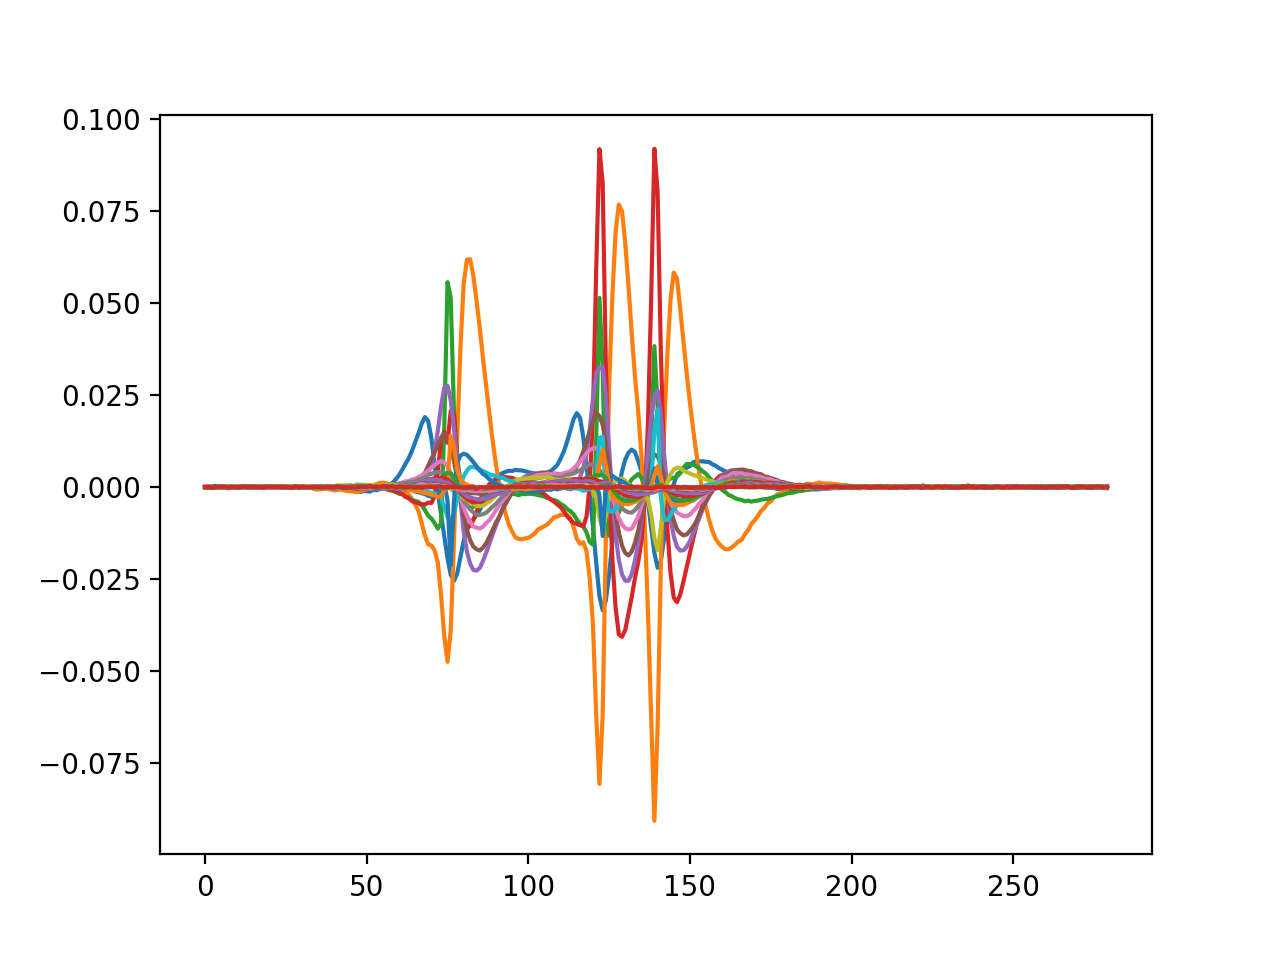

<IPython.core.display.Javascript object>


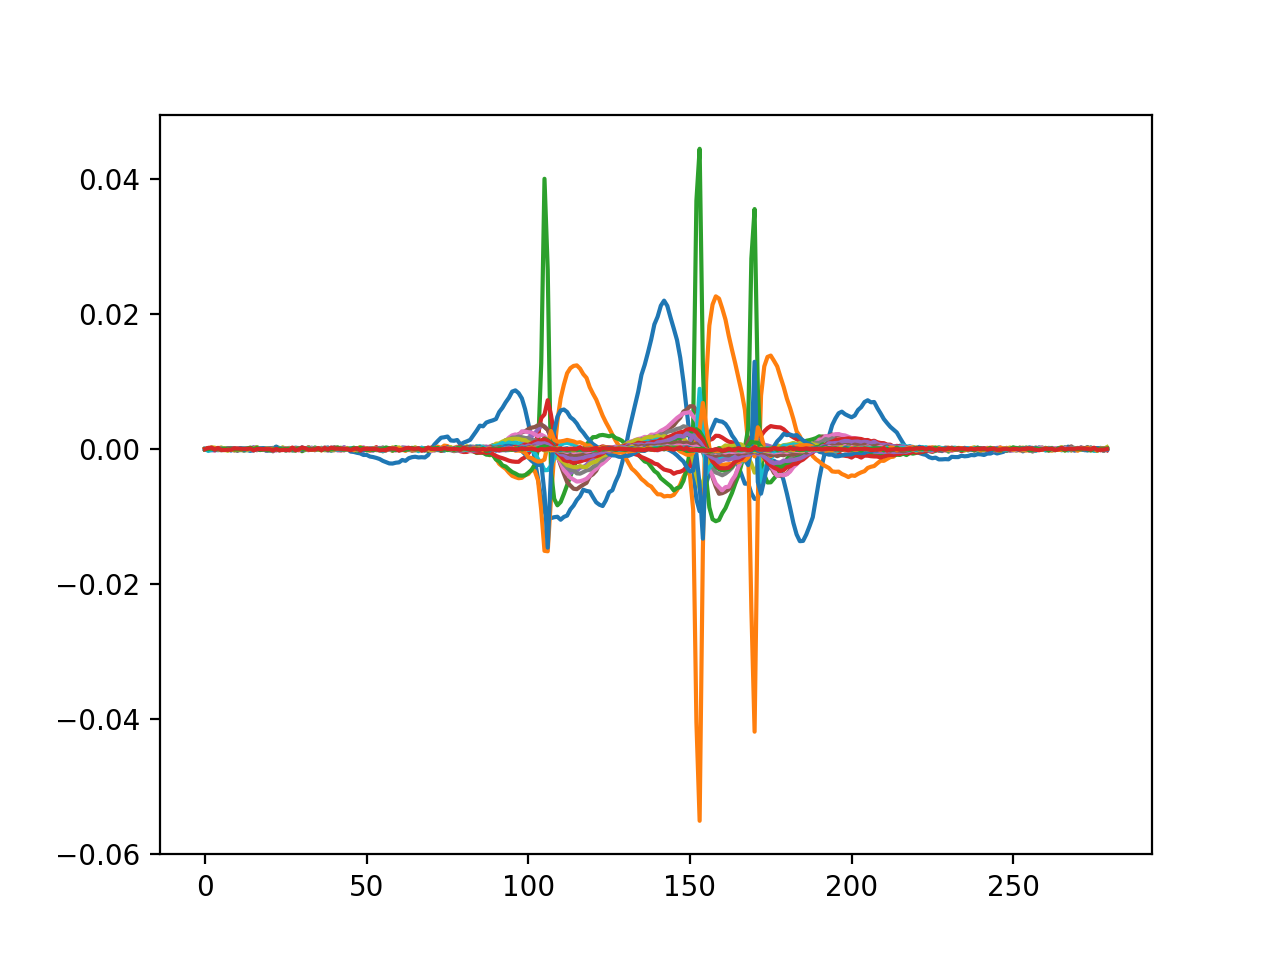

<IPython.core.display.Javascript object>


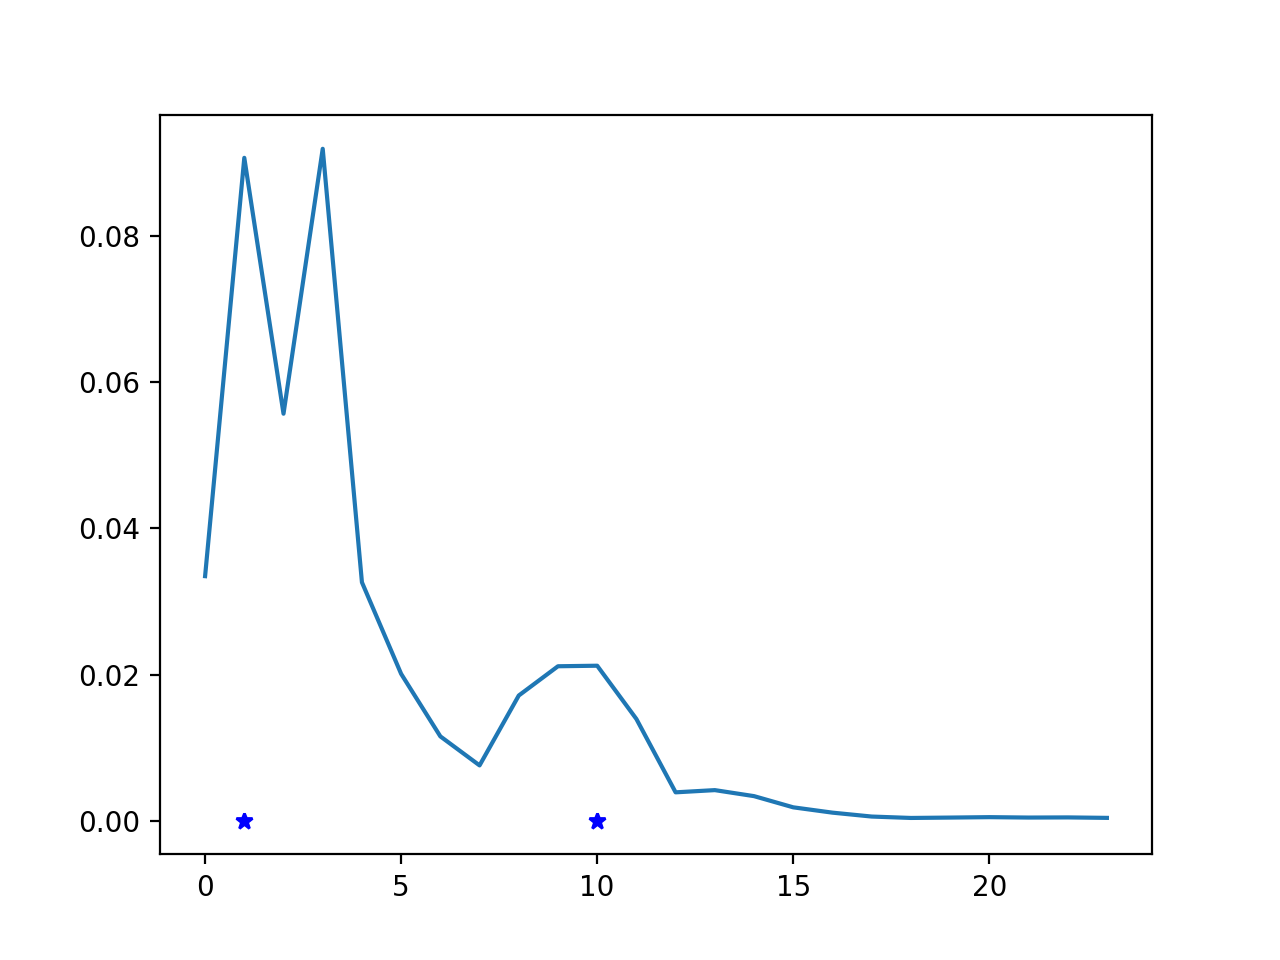

[0 1 2 3 4 5 6 7 8 9]


In [42]:
i=171

sos = signal.butter(2, 5, 'hp', fs=SAMPLING_RATE, output='sos')
filtered_wav1 = signal.sosfilt(sos, event_list[i].wav1[:, :24], axis=0)
filtered_wav2 = signal.sosfilt(sos, event_list[i].wav2[:, :24], axis=0)
print(event_list[i].timestamp + datetime.timedelta(hours=11))
print(identify_lane3(event_list[i], lane_sensor_1))
plt.figure()
plt.clf()
plt.plot(filtered_wav1)

plt.figure()
plt.clf()
plt.plot(filtered_wav2)

# lane assignment test region
lane_trace = pd.DataFrame()
for j in range(24):
    lane_trace['sensor{}'.format(j+1)]=event_detection(event_list[i].wav1[:,j], threshold=0.002, seg_length=3)

plt.figure()
# lane_combined = np.sum(lane_trace, axis=0)
lane_combined_1 = np.max(np.abs(filtered_wav1), axis=0)
lane_combined_2 = np.max(np.abs(filtered_wav2), axis=0)
peaks_lane = signal.find_peaks(lane_combined_1+lane_combined_2, prominence=0.002, distance=3)
# print(int(np.average(peaks_lane[0])) in lane_sensor_1)
print(lane_sensor_1)
plt.plot(np.asarray(lane_combined_1))
plt.plot(peaks_lane[0], [0,]*len(peaks_lane[0]), '*b')

In [61]:
lane_sensor_1 = np.asarray(lane_sensor)-1
print(lane_sensor_1)
is_inlane = []
for i in range(len(event_list)):
    if identify_lane3(event_list[i], lane_sensor_1, total_sensorn=24, threshold=0.0015, left_wheel_index=0) == 1:
        print('Vehicle on the lane event!#{}'.format(i))
        is_inlane.append(i)

[0 1 2 3 4 5 6 7 8 9]
Vehicle on the lane event!#0
Vehicle on the lane event!#1
Vehicle on the lane event!#2
Vehicle on the lane event!#3
Vehicle on the lane event!#4
Vehicle on the lane event!#5
Vehicle on the lane event!#6
Vehicle on the lane event!#7
Vehicle on the lane event!#8
Vehicle on the lane event!#9
Vehicle on the lane event!#10
Vehicle on the lane event!#11
Vehicle on the lane event!#12
Vehicle on the lane event!#13
Vehicle on the lane event!#14
Vehicle on the lane event!#15
Vehicle on the lane event!#16
Vehicle on the lane event!#17
Vehicle on the lane event!#18
Vehicle on the lane event!#19
Vehicle on the lane event!#20
Vehicle on the lane event!#21
Vehicle on the lane event!#22
Vehicle on the lane event!#25
No wheel found!
Vehicle on the lane event!#27
Vehicle on the lane event!#28
Vehicle on the lane event!#29
Vehicle on the lane event!#30
Vehicle on the lane event!#31
Vehicle on the lane event!#32
Vehicle on the lane event!#33
Vehicle on the lane event!#34
Vehicle on t

In [62]:
detected_events = []
detected_event_property = []
for i in is_inlane:
    event_prop_temp = EventProperties()
    event_prop_temp.timestamp=event_list[i].timestamp
    detected_events.append(event_list[i])
    detected_event_property.append(event_prop_temp)
print('Total on the lane:{}'.format(len(detected_events)))

Total on the lane:40


In [63]:
np.savez_compressed('Francis_1201_0930_lane_1_trial_1219_filtered_triggered_events.npz', events=detected_events)

2020-11-20 09:03:14.916566
[0 1 2 3 4 5 6 7 8 9]
1


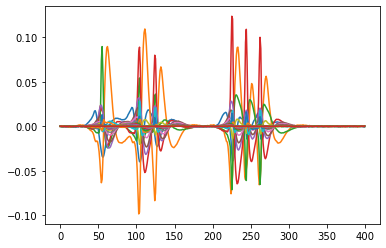

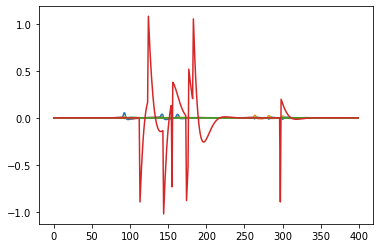

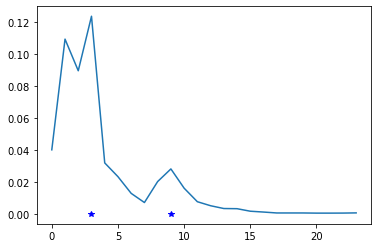

In [71]:
i=39
sos = signal.butter(2, 5, 'hp', fs=SAMPLING_RATE, output='sos')
filtered_wav1 = signal.sosfilt(sos, detected_events[i].wav1[:, :24], axis=0)
filtered_wav2 = signal.sosfilt(sos, detected_events[i].wav2[:, :24], axis=0)
print(detected_events[i].timestamp + datetime.timedelta(hours=11))
plt.figure()
plt.clf()
plt.plot(filtered_wav1)

plt.figure()
plt.clf()
plt.plot(filtered_wav2)

# lane assignment test region
lane_trace = pd.DataFrame()
for j in range(24):
    lane_trace['sensor{}'.format(j+1)]=event_detection(event_list[i].wav1[:,j], threshold=0.002, seg_length=3)

plt.figure()
# lane_combined = np.sum(lane_trace, axis=0)
lane_combined_1 = np.max(np.abs(filtered_wav1), axis=0)
lane_combined_2 = np.max(np.abs(filtered_wav2), axis=0)
peaks_lane = signal.find_peaks(lane_combined_1, prominence=0.0015, distance=5)
# print(int(np.average(peaks_lane[0])) in lane_sensor_1)
print(lane_sensor_1)
plt.plot(np.asarray(lane_combined_1))
plt.plot(peaks_lane[0], [0,]*len(peaks_lane[0]), '*b')
print(identify_lane3(detected_events[i], lane_sensor_1, total_sensorn=25, threshold=0.0015, left_wheel_index=0))

In [72]:
len(detected_events)

40

2020-11-20 09:00:38.648309


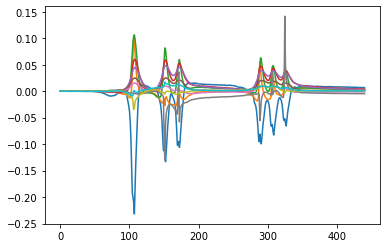

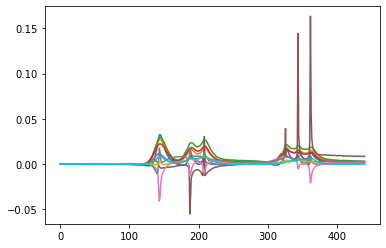

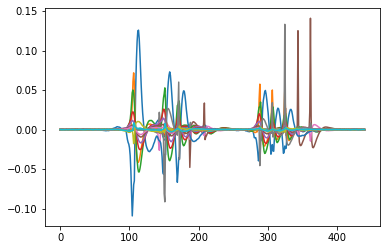

In [73]:
i=len(detected_events)-1
lane_sensor_1 = np.asarray(lane_sensor)
plt.figure()
plt.clf()
plt.plot(detected_events[i].wav1[:,lane_sensor_1])

plt.figure()
plt.clf()
plt.plot(detected_events[i].wav2[:,lane_sensor_1])

sos = signal.butter(2, 5, 'hp', fs=SAMPLING_RATE, output='sos')

filtered_wav2 = signal.sosfilt(sos, detected_events[i].wav2[:,lane_sensor_1], axis=0)
filtered_wav1 = signal.sosfilt(sos, detected_events[i].wav1[:, lane_sensor_1], axis=0)
    
print(detected_events[i].timestamp + datetime.timedelta(hours=11))

plt.figure()
plt.clf()
plt.plot(filtered_wav2)
plt.plot(filtered_wav1)

In [74]:
# lane assignment test region
i = 17
lane_trace = pd.DataFrame()
for j in range(24):
    lane_trace['sensor{}'.format(j+1)]=event_detection(detected_events[i].wav1[:,j], threshold=0.002, seg_length=3)

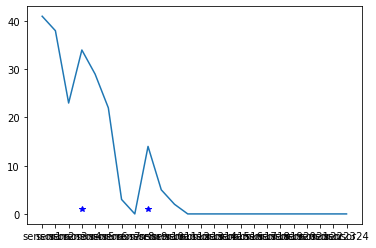

In [75]:
plt.figure()
peaks_lane = signal.find_peaks(np.sum(lane_trace, axis=0), prominence=1, distance=3)
plt.plot(np.sum(lane_trace, axis=0))
plt.plot(peaks_lane[0], [1,]*len(peaks_lane[0]), '*b')


In [76]:
# axle_trace = np.std(np.abs(event_list[i].wav1), axis=0)
axle_trace = np.max(np.abs(detected_events[i].wav2), axis=0)
axle_peaks = signal.find_peaks(axle_trace, prominence=0.01, distance=2)
print(len(axle_peaks[0]))
print(axle_peaks[0])
print(lane_sensor_1)
print(((axle_peaks[0]>=lane_sensor_1[0]) & (axle_peaks[0]<=lane_sensor_1[-1])).sum())

1
[6]
[ 1  2  3  4  5  6  7  8  9 10]
1


6.0
17


Text(0.5, 1.0, '#17. Timestamp: 2020-11-20 09:00:38.648309')

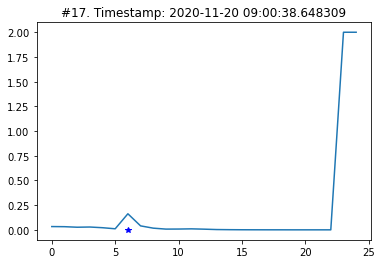

In [77]:
plt.figure()
plt.clf()
plt.plot(axle_trace)
plt.plot(axle_peaks[0], [0]*len(axle_peaks[0]), '*b')

# plt.plot(event_temp.wav1[:, 8])
print(np.average(axle_peaks[0]))
print(i)
plt.title('#{}. Timestamp: {}'.format(i, event_prop_list[i].timestamp+datetime.timedelta(hours=11)))